

# Projet 6 :

# Classifiez automatiquement des biens de consommation

## Préambule :

L'entreprise "Place de marché" est actuellement en train de développer une marketplace e-commerce. La plateforme permet aux vendeurs de proposer leurs articles aux acheteurs en publiant une photo et une description. Cependant, l'attribution manuelle des catégories aux articles par les vendeurs est peu fiable, et le volume d'articles actuellement présent sur la plateforme est encore limité. Afin d'améliorer l'expérience des utilisateurs et de préparer une future expansion, il est devenu nécessaire d'automatiser cette tâche.


## Mission

Notre mission consiste à étudier la faisabilité d'un moteur de classification automatique des articles pour notre marketplace. L'objectif est de mettre en place un système capable d'attribuer automatiquement des catégories aux articles en se basant sur leur description et leur image. 


### Chargement des bibliothèques et des données

In [1]:
!pip install --upgrade numpy
!pip install tensorflow
!pip install --upgrade tensorflow
!pip install --upgrade transformers
!pip install --upgrade torch
!pip install --upgrade tensorflow_hub
!pip install --upgrade tensorflow_text
!pip install spacy
!python -m spacy download fr_core_news_sm
!pip install -U spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import SnowballStemmer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from nltk.stem.snowball import SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from gensim.models import Word2Vec
import tensorflow as tf
from transformers import BertTokenizer, BertModel
import torch
import tensorflow_hub as hub
import tensorflow_text
!pip install WordCloud
from wordcloud import WordCloud

  Using cached numpy-1.25.0-cp39-cp39-macosx_10_9_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.25.0 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.25.0 which is incompatible.
  Using cached numpy-1.23.5-cp39-cp39-macosx_10_9_x86_64.whl (18.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
ERROR: pip's dependency resolver does

2023-06-18 03:51:34.697083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package wordnet to /Users/azizi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/azizi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Chargement des données 
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [3]:
# Afficher les 5 premières lignes du jeu de données df
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
# Nombre de lignes et colonnes (taille du jeu de données df)

print(f"Nombre de (lignes, colonnes) = {df.shape}")

Nombre de (lignes, colonnes) = (1050, 15)


In [5]:
# Nombre des doublons dans le jeu de données df

print(f"Nombre des doublons = {df.duplicated(keep=False).sum()}")

Nombre des doublons = 0


In [6]:
# Informations sur le jeu de données df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

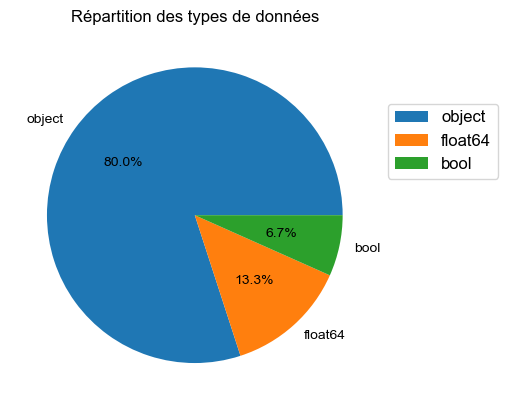

In [7]:
# visualisation de types des données dans le jeu de données df

df.dtypes.value_counts().plot(kind='pie', autopct='%1.1f%%', 
                                   title="Répartition des types de données",
                                   legend=False, label="")

ax = plt.gca()
ax.legend(loc="center left",
          fontsize=12,
          bbox_to_anchor=(1, 0.2, 0.5, 1))
sns.set_theme()
plt.show()

In [8]:
# % de valeurs manquantes par colonne
df.isna().mean()*100

uniq_id                     0.000000
crawl_timestamp             0.000000
product_url                 0.000000
product_name                0.000000
product_category_tree       0.000000
pid                         0.000000
retail_price                0.095238
discounted_price            0.095238
image                       0.000000
is_FK_Advantage_product     0.000000
description                 0.000000
product_rating              0.000000
overall_rating              0.000000
brand                      32.190476
product_specifications      0.095238
dtype: float64

Text(0.5, 1.0, '% Valeurs non nulles dans le jeu de données df')

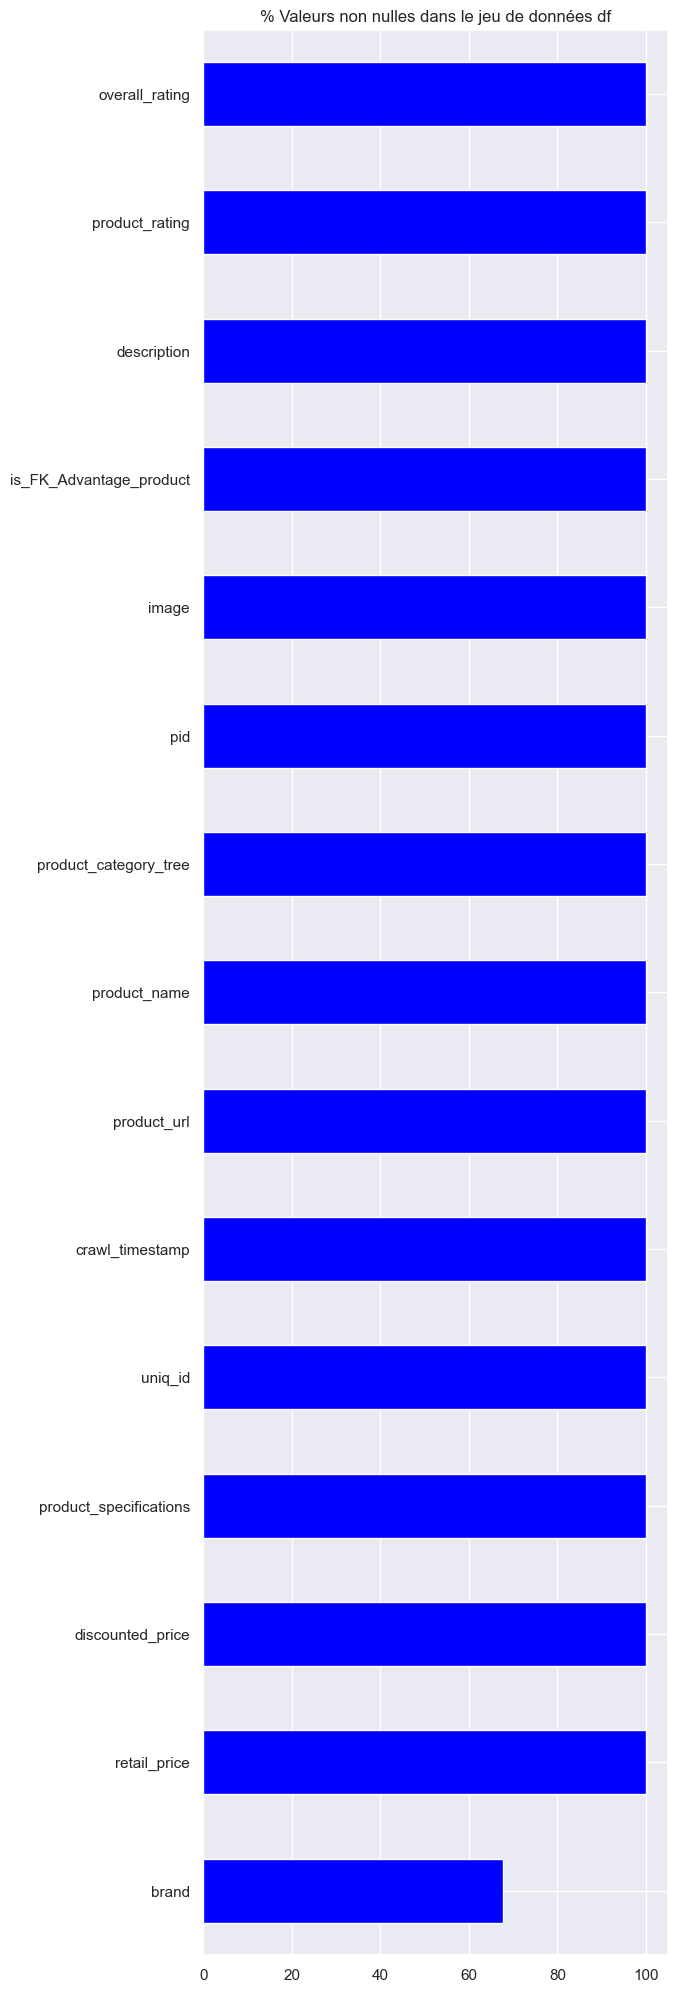

In [9]:
# visualisation du pourcentage de Valeurs manquantes dans le jeu de données df
sns.set_theme()
taille = df.shape
valeurs_notnull = df.notnull().sum()
valeurs_notnull = valeurs_notnull.sort_values(ascending=True)*100/taille[0]
figure = valeurs_notnull.plot(kind='barh',figsize=(6, 25),color='blue')
figure.set_title("% Valeurs non nulles dans le jeu de données df")

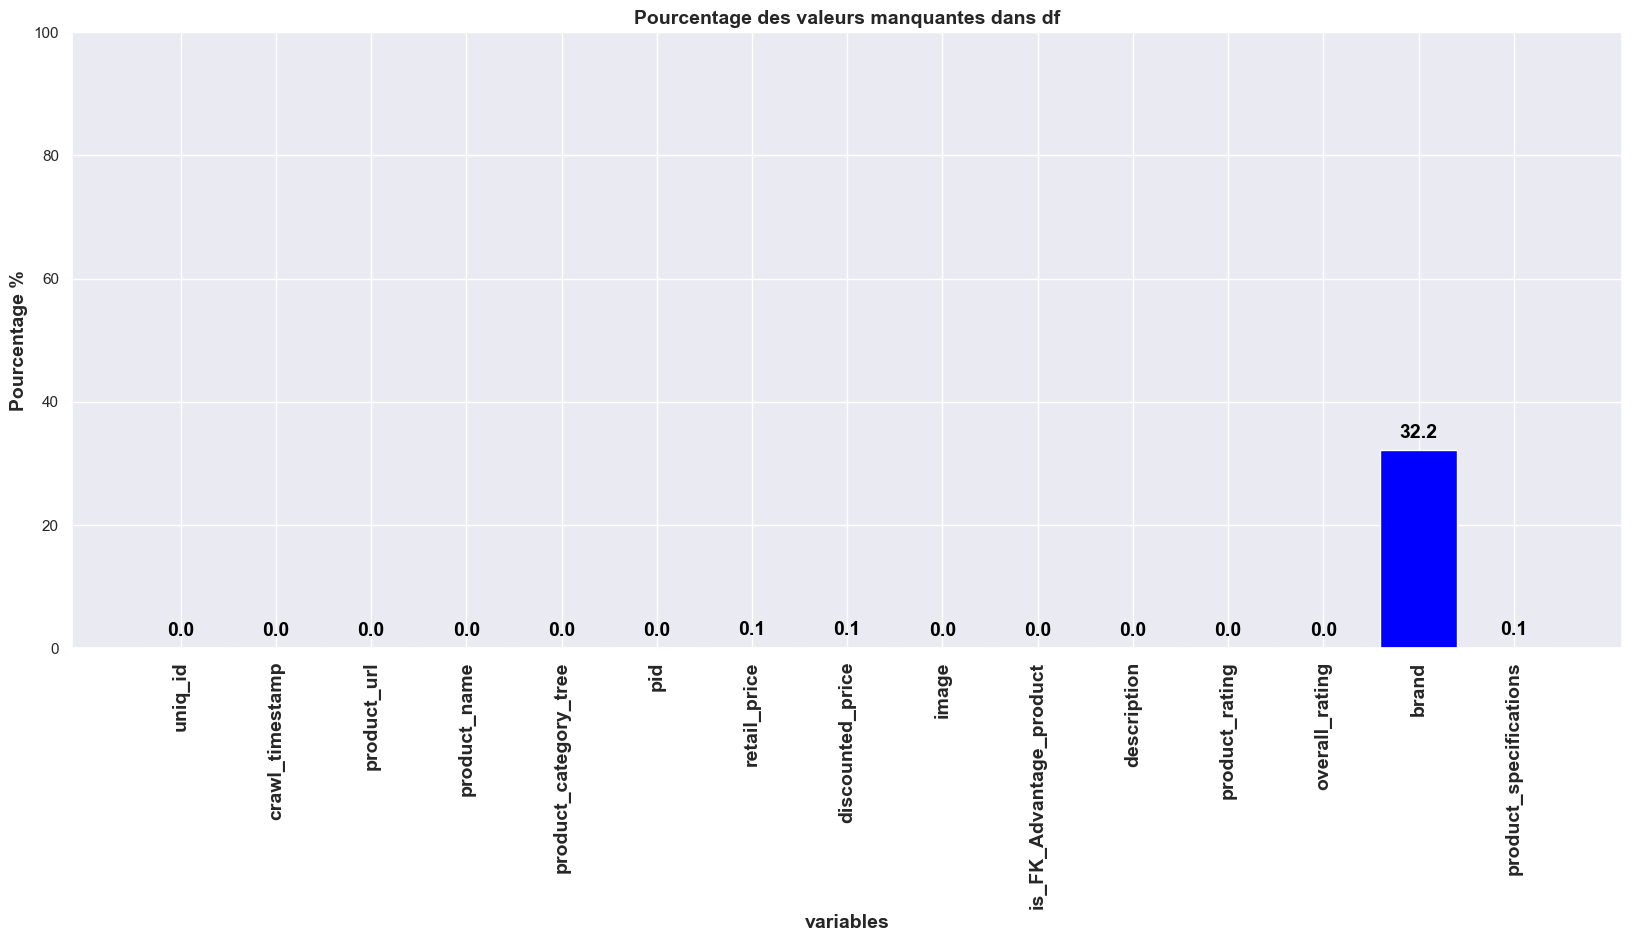

In [10]:
# Représentation graphique du pourcentage des valeurs manquantes pour chaque variable

sns.set_theme()
plt.figure(figsize=(20,8))
df_nan = (df.isna().mean()*100).round(1)
barplot=plt.bar(df_nan.keys(), df_nan.values, color="blue")
plt.bar_label(barplot, labels=df_nan.values, label_type= "edge", 
              weight='bold', padding=6, color= 'black', fontsize=14)
plt.xticks(rotation=90, weight='bold', fontsize=14)
plt.ylim([0,100])
plt.ylabel("Pourcentage %", weight='bold', fontsize=14)
plt.xlabel('variables', weight='bold', fontsize=14)
plt.title('Pourcentage des valeurs manquantes dans df', weight='bold', fontsize=14)
plt.show()

In [11]:
# Afficher les 5 premières lignes du jeu de données df
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [12]:
# liste contenant les noms des colonnes du dataframe df
df.columns.tolist()

['uniq_id',
 'crawl_timestamp',
 'product_url',
 'product_name',
 'product_category_tree',
 'pid',
 'retail_price',
 'discounted_price',
 'image',
 'is_FK_Advantage_product',
 'description',
 'product_rating',
 'overall_rating',
 'brand',
 'product_specifications']

### Description de chaque variable :

- uniq_id: Il s'agit d'une variable de type chaîne de caractères qui représente un identifiant unique pour chaque produit.
- crawl_timestamp: C'est une variable de type date/heure qui enregistre le moment où les données ont été collectées.
- product_url: Cette variable de type chaîne de caractères contient l'URL ou le lien vers la page du produit.
- product_name: Il s'agit d'une variable de type chaîne de caractères qui représente le nom ou le titre du produit.
- product_category_tree: Cette variable de type chaîne de caractères représente une structure hiérarchique décrivant la catégorie du produit.
- pid: Il s'agit d'une variable de type chaîne de caractères qui représente un identifiant spécifique attribué à chaque produit.
- retail_price: C'est une variable de type numérique (flottant ou entier) qui enregistre le prix de détail ou le prix d'origine du produit.
- discounted_price: Il s'agit d'une variable de type numérique (flottant ou entier) qui enregistre le prix réduit ou le prix promotionnel du produit.
- image:  Cette variable de type chaîne de caractères contient le nom de l'image du produit.
- is_FK_Advantage_product: C'est une variable de type booléen (True/False) indiquant si le produit bénéficie ou non d'un avantage spécifique sur la plateforme de commerce électronique.
- description: Il s'agit d'une variable de type chaîne de caractères qui contient la description détaillée du produit.
- product_rating: Cette variable de type chaîne de caractères représente la note ou l'évaluation attribuée au produit.
- overall_rating: C'est une variable de type chaîne de caractères qui représente la note globale ou la moyenne des évaluations de tous les produits d'une même catégorie ou d'une même marque.
- brand: Il s'agit d'une variable de type chaîne de caractères qui représente le nom de la marque ou du fabricant du produit.
- product_specifications: Cette variable contient les spécifications techniques ou détails spécifiques du produit.

### Choix et préparation des variables pour l'analyse des features textuelles
Nous sélectionnons les colonnes "product_name", "description" et "product_category_tree" du dataframe "df" et les stockons dans un nouveau dataset appelé "data".

Ensuite, nous ajoutons une nouvelle colonne à "data" appelée "product_description". Cette colonne est créée en fusionnant le contenu des colonnes "product_name" et "description", en utilisant un espace comme séparateur. Ainsi, chaque valeur de la colonne "product_description" sera composée du nom du produit suivi de sa description correspondante.

In [13]:
def extract_concat(df):
    '''
    Fonction pour extraire et concaténer les colonnes spécifiques d'un DataFrame
    '''
    
    # Extraction des colonnes spécifiques "product_name", "description" et "product_category_tree" du dataframe "df"
    data = df[['product_name', 'description', 'product_category_tree']].copy()

    # Création d'une nouvelle colonne "product_description" dans le dataframe "data"
    # Concaténation du contenu des colonnes "product_name" et "description" en utilisant ":" comme séparateur
    data.loc[:, 'product_description'] = df['product_name'].str.cat(df['description'], sep=' ')
    
    # Retourner le DataFrame mis à jour
    return data


In [14]:
data_concat = extract_concat(df)
data_concat

,product_name,description,product_category_tree,product_description
0,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",Elegance Polyester Multicolor Abstract Eyelet ...
1,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Sathiyas Cotton Bath Towel Specifications of S...
2,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Eurospa Cotton Terry Face Towel Set Key Featur...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",SANTOSH ROYAL FASHION Cotton Printed King size...
4,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Jaipur Print Cotton Floral King sized Double B...
...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Oren Empower Extra Large Self Adhesive Sticker...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Oren Empower Extra Large Self Adhesive Sticker...
1046,Wallmantra Large Vinyl Sticker Sticker,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Large Vinyl Sticker Sticker Wallman...
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Uberlyfe Extra Large Pigmented Polyvinyl Films...
1048,Wallmantra Medium Vinyl Sticker Sticker,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Wallmantra Medium Vinyl Sticker Sticker Buy Wa...


In [15]:
def preprocess_data(data_pre):
    '''
    Fonction pour prétraiter les données :
    - Extraction de la première catégorie des produits
    - Suppression des colonnes inutiles
    '''
    
    # Définition de la fonction pour extraire la première catégorie de l'arborescence des produits
    def categorie(row):
        categories = row.split('>>')  # Séparation des catégories par le séparateur ">>"
        if len(categories) > 0:
            first_category = categories[0].strip()  # Retourne la première catégorie après avoir supprimé les espaces en début et fin
            first_category = first_category.lstrip('["')  # Supprimer le caractère "[" au début de la catégorie
            return first_category
        else:
            return None

    # Ajout d'une nouvelle colonne "premiere_categorie" avec la première catégorie de l'arborescence des produits
    data_concat['categorie'] = data_concat['product_category_tree'].apply(lambda row: categorie(row))

    # Suppression des colonnes "product_category_tree", "product_name" et "description"
    data_concat.drop(['product_category_tree', 'product_name', 'description'], axis=1, inplace=True)

    # Retourner le DataFrame mis à jour
    return data_pre



In [16]:
data = preprocess_data(data_concat)
data

,product_description,categorie
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing
1,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing
...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker Wallman...,Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker Buy Wa...,Baby Care


In [17]:
# nombre de valeurs uniques dans la variable 'catégorie'
data['categorie'].nunique()

7

In [18]:
data['categorie'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

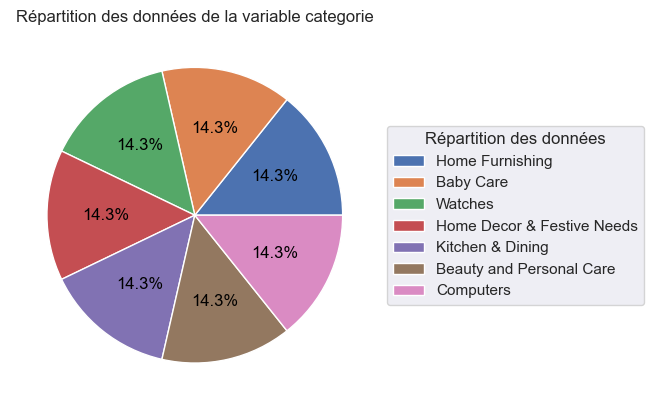

In [19]:
# Répartition des données de la variable categorie
plt.title('Répartition des données de la variable categorie', size=12)
wedges, texts, autotexts = plt.pie(data['categorie'].value_counts(),
                                  #labels = data['categorie'].unique(),
                                   autopct='%1.1f%%', textprops={'fontsize': 12, 
                                     'color' : 'Black'})
    
ax = plt.gca()
sns.set_theme()
ax.legend(wedges, data['categorie'].unique(),
          title='Répartition des données',
          loc="center left",
          fontsize=11,
          bbox_to_anchor=(1., 0.25, 0.2, 0.5))
plt.show()

In [20]:
# Affichage du contenu de la variable "product_description"
data.product_description

0       Elegance Polyester Multicolor Abstract Eyelet ...
1       Sathiyas Cotton Bath Towel Specifications of S...
2       Eurospa Cotton Terry Face Towel Set Key Featur...
3       SANTOSH ROYAL FASHION Cotton Printed King size...
4       Jaipur Print Cotton Floral King sized Double B...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker Wallman...
1047    Uberlyfe Extra Large Pigmented Polyvinyl Films...
1048    Wallmantra Medium Vinyl Sticker Sticker Buy Wa...
1049    Uberlyfe Large Vinyl Sticker Buy Uberlyfe Larg...
Name: product_description, Length: 1050, dtype: object

In [21]:
# nombre de valeurs uniques dans la variable 'product_description'
data['product_description'].nunique()

1050

In [22]:
# longueur de chaque élément dans la colonne "product_description"
data.product_description.apply(lambda i : len(i))

0       1479
1        471
2       1294
3        922
4       1251
        ... 
1045    2479
1046    1699
1047     328
1048     250
1049     216
Name: product_description, Length: 1050, dtype: int64

Longueur des éléments dans la colonne "product_description"


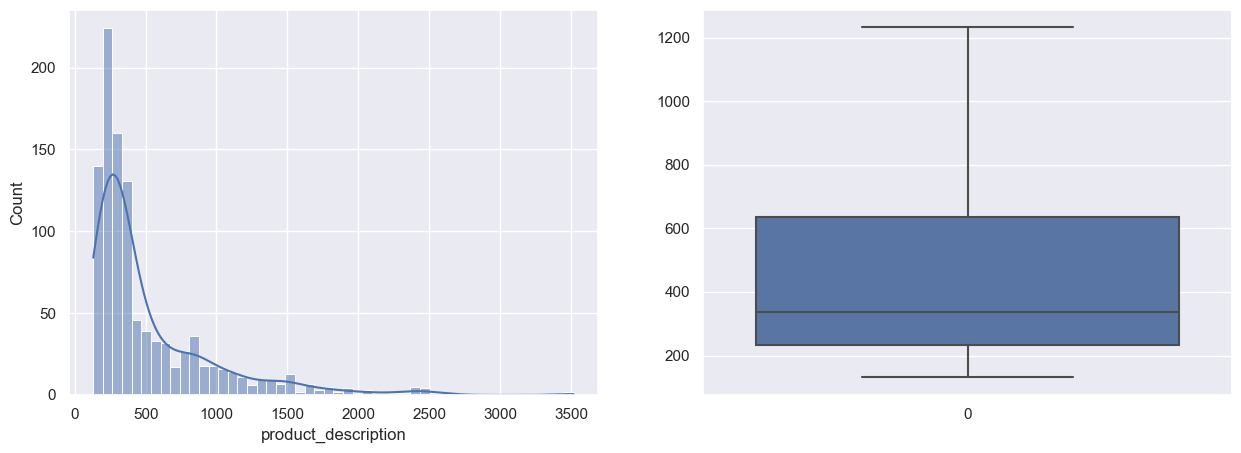

_________________________
Statistiques descriptives
_________________________
count    1050.000000
mean      519.922857
std       461.283707
min       131.000000
25%       233.000000
50%       336.000000
75%       636.000000
max      3519.000000
Name: product_description, dtype: float64
_________________________


In [23]:
# Longueur de chaque élément dans la colonne "product_description"
long = data.product_description.str.len()

# Distribution de la variable "product_description" avec displot et boxplot
sns.set_theme()
print('Longueur des éléments dans la colonne "product_description"')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(data=long, kde=True, bins=50, ax=ax1)
sns.boxplot(data=long, ax=ax2, showfliers=False)
plt.show()

print('_'*25)
print('Statistiques descriptives')
print('_'*25)
print(long.describe())
print('_'*25)


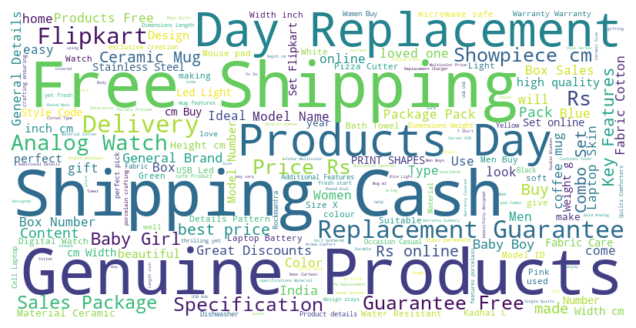

In [24]:
# Fusionner toutes les descriptions de produits en une seule chaîne de caractères
texte = ' '.join(data['product_description'])

# Créer un objet WordCloud
nuage_mots = WordCloud(width=800, height=400, background_color='white').generate(texte)

# Afficher le nuage de mots 
plt.figure(figsize=(8, 4))
plt.imshow(nuage_mots, interpolation='bilinear')
plt.axis('off')
plt.show()


### Prétraitement des données textes :


In [25]:
def preprocess_words(words):
    '''
    Fonction pour prétraiter une liste de mots :
    - Suppression de la ponctuation
    - Suppression des mots de liaison (stop words)
    - Conversion en minuscules
    '''
    
    # Suppression de la ponctuation
    words = [word for word in words if word not in string.punctuation]
    
    # Suppression des mots de liaison
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]
    
    # Conversion en minuscules
    words = [word.lower() for word in words]
    
    # Retourner la liste des mots prétraités
    return words

### tokenizer, stemmer, et lemmatiser

- Tokenisation : La tokenisation est le processus de division d'un texte en unités linguistiques plus petites, appelées tokens. Ces tokens peuvent être des mots, des phrases ou même des caractères individuels. La tokenisation est souvent la première étape dans le traitement du langage naturel car elle permet de segmenter le texte en éléments significatifs pour une analyse ultérieure.
- Stemming : Le stemming est le processus de réduction d'un mot à sa forme de base ou à sa racine, en supprimant les suffixes ou les préfixes. L'objectif du stemming est de regrouper les variantes d'un mot sous une seule forme commune, ce qui permet de simplifier l'analyse des mots et d'améliorer la récupération d'informations. 
- Lemmatisation : La lemmatisation est également un processus de réduction des mots, mais contrairement au stemming, il tente de déterminer la forme canonique ou le lemme d'un mot en utilisant des règles morphologiques complexes et en se référant à un dictionnaire de mots. La lemmatisation prend en compte la signification du mot dans le contexte et renvoie un lemme qui est un mot réel existant. La lemmatisation est plus précise que le stemming car elle tient compte de la morphologie et de la syntaxe de la langue.

### NLTK

NLTK (Natural Language Toolkit) est une librairie populaire de traitement du langage naturel (NLP) en Python. Elle est utilisée pour effectuer différentes tâches de NLP, telles que la tokenization, la lemmatisation, le POS tagging, la reconnaissance d'entités nommées, l'analyse syntaxique, la classification de texte, la traduction automatique, et bien plus encore.
NLTK est une librairie puissante et largement utilisée dans le domaine du traitement du langage naturel, notamment pour l'apprentissage et l'enseignement de la linguistique informatique. Elle offre une grande flexibilité et permet de réaliser des tâches de NLP à différents niveaux de complexité.

### Fonctions pour tokenizer, stemmer, et lemmatiser un texte  en utilisant la bibliothèque NLTK

In [26]:
def tokenize_nltk(text):
    '''
    Fonction pour tokenizer un texte en mots
    '''
    
    tokens = word_tokenize(text, language='english')
    
    # Retourner la liste des mots tokenizés
    return tokens


In [27]:
def stem_nltk(sentence):
    '''
    Fonction pour "stemmer" une phrase en réduisant les mots à leur racine
    '''
    
    # Créer une instance du stemmer
    stemmer = SnowballStemmer('english')
    
    # Séparer la phrase en mots
    words = sentence.split()
    
    # "Stemming" de chaque mot
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Rejoindre les mots "stemmés" pour reformer la phrase
    stemmed_sentence = ' '.join(stemmed_words)
    
    # Retourner la phrase "stemmée"
    return stemmed_sentence


In [28]:
def lemmatize_nltk(sentence):
    '''
    Fonction pour "lemmatiser" une phrase en réduisant les mots à leur forme canonique (lemme)
    '''
    
    # Créer une instance du lemmatiseur
    lemmatizer = WordNetLemmatizer()
    
    # Tokenization des mots dans la phrase
    tokens = word_tokenize(sentence, language='english')
    
    # "Lemmatisation" de chaque mot
    lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Rejoindre les mots "lemmatisés" pour reformer la phrase
    lemmatized_sentence = ' '.join(lemmatized_words)
    
    # Retourner la phrase "lemmatisée"
    return lemmatized_sentence


### spaCy
spaCy est une bibliothèque Python open-source et très populaire pour le traitement du langage naturel (NLP). Elle offre une large gamme de fonctionnalités pour analyser et traiter les textes de manière efficace.
Spacy est apprécié pour sa vitesse d'exécution, sa facilité d'utilisation et sa grande efficacité dans le traitement de gros volumes de données textuelles.

### Fonctions pour tokenizer, stemmer, et lemmatiser un texte en utilisant la bibliothèque spaCy.

In [29]:
nlp = spacy.load("en_core_web_sm")
def tokenize_spacy(text, nlp):
    '''
    Fonction pour tokeniser un texte à l'aide d'un modèle spaCy
    '''
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens


In [30]:
def stem_spacy(text):
    '''
    Fonction pour effectuer le stemming d'un texte en utilisant spaCy
    '''
    doc = nlp(text)
    
    stemmed_words = [token.lemma_ for token in doc]
    stemmed_sentence = ' '.join(stemmed_words)
    
    return stemmed_sentence


In [31]:
def lemmatize_spacy(text, nlp):
    '''
    Fonction pour effectuer la lemmatisation d'un texte en utilisant spaCy
    '''
    doc = nlp(text)
    
    lemmatized_words = [token.lemma_ for token in doc]
    lemmatized_sentence = ' '.join(lemmatized_words)
    return lemmatized_sentence


### Tester les fonctions de tokenizer, stemmer, et lemmatiser

In [32]:
print('*'*95)
print('_'*95)
# Test : Texte à tokenizer
text = "Elegance Polyester Multicolor Abstract Eyelet ..."
print('Texte à tokenizer:', text)
print('_'*95)

# Appel des fonction pour tokeniser,stemmer et “lemmatiser avec nltk
tokenized_text = tokenize_nltk(text)
stemmed_sentence = stem_nltk(text)
lemmatized_sentence = lemmatize_nltk(text)


# Appel des fonction pour tokeniser,stemmer et “lemmatiser avec spaCy
tokenized_text = tokenize_spacy(text, nlp)
stemmed_text = stem_spacy(text)
lemmatized_text = lemmatize_spacy(text, nlp)

# Affichage des tokens avec nltk et spacy
print('tokenized_text avec nltk:', tokenized_text)
print('tokenized_text avec SpaCy:', tokenized_text)
print('_'*95)

# Affichage de la phrase "stemmée" avec nltk et spaCy
print('stemmed_sentence avec nltk:', stemmed_sentence)
print('stemmed_sentence avec SpaCy:', stemmed_text)
print('_'*95)

# Affichage de la phrase "lemmatisée" avec nltk et spaCy
print('lemmatized avec nltk:', lemmatized_sentence)
print('lemmatized avec SpaCy:', lemmatized_text)

print('_'*95)
print('*'*95)

***********************************************************************************************
_______________________________________________________________________________________________
Texte à tokenizer: Elegance Polyester Multicolor Abstract Eyelet ...
_______________________________________________________________________________________________
tokenized_text avec nltk: ['Elegance', 'Polyester', 'Multicolor', 'Abstract', 'Eyelet', '...']
tokenized_text avec SpaCy: ['Elegance', 'Polyester', 'Multicolor', 'Abstract', 'Eyelet', '...']
_______________________________________________________________________________________________
stemmed_sentence avec nltk: eleg polyest multicolor abstract eyelet ...
stemmed_sentence avec SpaCy: Elegance Polyester Multicolor Abstract Eyelet ...
_______________________________________________________________________________________________
lemmatized avec nltk: Elegance Polyester Multicolor Abstract Eyelet ...
lemmatized avec SpaCy: Elegance Polye

In [33]:
data.head(3)

,product_description,categorie
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing
1,Sathiyas Cotton Bath Towel Specifications of S...,Baby Care
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care


In [34]:
# % de valeurs manquantes par colonne
data.isna().mean()*100

product_description    0.0
categorie              0.0
dtype: float64

### Filtrer les mots qui contiennent 2 lettres ou moins

In [35]:
def remove_short_words(text):
    # Séparer le texte en mots
    words = text.split()
    # Filtrer les mots qui contiennent 2 lettres ou moins
    filtered_words = [word for word in words if len(word) > 2]
    # Rejoindre les mots restants en une chaîne de caractères
    filtered_text = " ".join(filtered_words)
    return filtered_text


In [36]:
# appliquer la fonction remove_short_words
data['product_description'] = data['product_description'].apply(remove_short_words)
data

,product_description,categorie
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing
1,Sathiyas Cotton Bath Towel Specifications Sath...,Baby Care
2,Eurospa Cotton Terry Face Towel Set Key Featur...,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing
...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker...,Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker Wallman...,Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker Buy Wa...,Baby Care


### Tokenization à l'aide de NLTK

In [37]:
# Appliquer la tokenization à la colonne 'product_description' du dataframe 'data'
data['product_description'] = data['product_description'].apply(tokenize_nltk)
data

,product_description,categorie
0,"[Elegance, Polyester, Multicolor, Abstract, Ey...",Home Furnishing
1,"[Sathiyas, Cotton, Bath, Towel, Specifications...",Baby Care
2,"[Eurospa, Cotton, Terry, Face, Towel, Set, Key...",Baby Care
3,"[SANTOSH, ROYAL, FASHION, Cotton, Printed, Kin...",Home Furnishing
4,"[Jaipur, Print, Cotton, Floral, King, sized, D...",Home Furnishing
...,...,...
1045,"[Oren, Empower, Extra, Large, Self, Adhesive, ...",Baby Care
1046,"[Wallmantra, Large, Vinyl, Sticker, Sticker, W...",Baby Care
1047,"[Uberlyfe, Extra, Large, Pigmented, Polyvinyl,...",Baby Care
1048,"[Wallmantra, Medium, Vinyl, Sticker, Sticker, ...",Baby Care


### Suppression de la ponctuation,  Suppression des stop words et Conversion en minuscules

In [38]:
# appliquer la fonction preprocess_words pour :
# Suppression de la ponctuation
# Suppression des mots de liaison (stop words)
# Conversion en minuscules
data['product_description'] = data['product_description'].apply(preprocess_words)
data

,product_description,categorie
0,"[elegance, polyester, multicolor, abstract, ey...",Home Furnishing
1,"[sathiyas, cotton, bath, towel, specifications...",Baby Care
2,"[eurospa, cotton, terry, face, towel, set, key...",Baby Care
3,"[santosh, royal, fashion, cotton, printed, kin...",Home Furnishing
4,"[jaipur, print, cotton, floral, king, sized, d...",Home Furnishing
...,...,...
1045,"[oren, empower, extra, large, self, adhesive, ...",Baby Care
1046,"[wallmantra, large, vinyl, sticker, sticker, w...",Baby Care
1047,"[uberlyfe, extra, large, pigmented, polyvinyl,...",Baby Care
1048,"[wallmantra, medium, vinyl, sticker, sticker, ...",Baby Care


### Supprimer les nombres

In [39]:
def remove_numbers(text):
    # Supprimer les nombres de la chaîne de caractères
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers

In [40]:
# appliquer la fonction remove_punctuation
data['product_description'] = data['product_description'].astype(str).apply(remove_numbers)
data

,product_description,categorie
0,"['elegance', 'polyester', 'multicolor', 'abstr...",Home Furnishing
1,"['sathiyas', 'cotton', 'bath', 'towel', 'speci...",Baby Care
2,"['eurospa', 'cotton', 'terry', 'face', 'towel'...",Baby Care
3,"['santosh', 'royal', 'fashion', 'cotton', 'pri...",Home Furnishing
4,"['jaipur', 'print', 'cotton', 'floral', 'king'...",Home Furnishing
...,...,...
1045,"['oren', 'empower', 'extra', 'large', 'self', ...",Baby Care
1046,"['wallmantra', 'large', 'vinyl', 'sticker', 's...",Baby Care
1047,"['uberlyfe', 'extra', 'large', 'pigmented', 'p...",Baby Care
1048,"['wallmantra', 'medium', 'vinyl', 'sticker', '...",Baby Care


### Lemmatisation à l'aide de Spacy

In [41]:
# lemmatize à l'aide de Spacy
data['product_description'] = data['product_description'].apply(lambda x: lemmatize_spacy(x, nlp))
data

,product_description,categorie
0,"[ ' elegance ' , ' polyester ' , ' multicolor ...",Home Furnishing
1,"[ ' sathiyas ' , ' cotton ' , ' bath ' , ' tow...",Baby Care
2,"[ ' eurospa ' , ' cotton ' , ' terry ' , ' fac...",Baby Care
3,"[ ' santosh ' , ' royal ' , ' fashion ' , ' co...",Home Furnishing
4,"[ ' jaipur ' , ' print ' , ' cotton ' , ' flor...",Home Furnishing
...,...,...
1045,"[ ' oren ' , ' empower ' , ' extra ' , ' large...",Baby Care
1046,"[ ' wallmantra ' , ' large ' , ' vinyl ' , ' s...",Baby Care
1047,"[ ' uberlyfe ' , ' extra ' , ' large ' , ' pig...",Baby Care
1048,"[ ' wallmantra ' , ' medium ' , ' vinyl ' , ' ...",Baby Care


On va créer une fonction appelée preprocess_text qui regroupe les fonctions : remove_short_words, tokenize_nltk, preprocess_words, remove_numbers et lemmatize_spacy. 

Cette fonction permettra d'effectuer les différentes étapes de prétraitement nécessaires, telles que la suppression des mots courts, la tokenisation, le prétraitement des mots restants, la suppression des nombres et enfin la lemmatisation du texte.

Ensuite, nous utiliserons une fonction nommée avant_apres pour afficher des informations sur les tokens avant et après le prétraitement.

In [42]:
def preprocess_text(text):
    
    # Fonction pour enlever les mots courts
    def remove_short_words(text):
        words = text.split()
        filtered_words = [word for word in words if len(word) > 2]
        filtered_text = " ".join(filtered_words)
        return filtered_text
    
    # Fonction pour tokeniser un texte à l'aide de NLTK
    def tokenize_nltk(text):
        tokens = word_tokenize(text)
        return tokens
    
    # Fonction pour prétraiter une liste de mots
    def preprocess_words(words):
        words = [word for word in words if word not in string.punctuation]
        words = [word for word in words if word.lower() not in stopwords.words('english')]
        words = [word.lower() for word in words]
        return words
    
    # Fonction pour enlever les nombres
    def remove_numbers(text):
        text_without_numbers = re.sub(r'\d+', '', text)
        return text_without_numbers
    
    # Fonction pour lemmatiser le texte avec spaCy
    def lemmatize_spacy(text, nlp):
        doc = nlp(text)
        lemmatized_words = [token.lemma_ for token in doc]
        lemmatized_sentence = ' '.join(lemmatized_words)
        return lemmatized_sentence
    
    # Charger le modèle spaCy pour la lemmatisation
    nlp = spacy.load('en_core_web_sm')
    
    # Appliquer les étapes de prétraitement
    text = remove_short_words(text)
    tokens = tokenize_nltk(text)
    filtered_text = ' '.join(tokens)
    filtered_text = remove_numbers(filtered_text)
    tokens = nltk.word_tokenize(filtered_text)
    tokens = preprocess_words(tokens)
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Définir une fonction  "avant_apres" pour afficher des informations sur les tokens avant et après le prétraitement

def avant_apres(description):
    original_tokens = word_tokenize(description)
    preprocessed_tokens = preprocess_text(description)
    
    num_original_tokens = len(original_tokens)
    num_preprocessed_tokens = len(word_tokenize(preprocessed_tokens))
    
    unique_original_tokens = set(original_tokens)
    unique_preprocessed_tokens = set(word_tokenize(preprocessed_tokens))
    
    print('_'*40)
    print("**  Informations sur les tokens avant le preprocessing :")
    print(f"Nombre total de tokens : {num_original_tokens}")
    print(f"Nombre de tokens uniques : {len(unique_original_tokens)}")
    print(f"Tokens uniques : {unique_original_tokens}")
    print('')
    print("**  Informations sur les tokens après le preprocessing :")
    print(f"Nombre total de tokens : {num_preprocessed_tokens}")
    print(f"Nombre de tokens uniques : {len(unique_preprocessed_tokens)}")
    print(f"Tokens uniques : {unique_preprocessed_tokens}")


# Appliquer la fonction sur les 3 premières lignes de la colonne 'product_description'
data['product_description'].head(3).apply(avant_apres)



________________________________________
**  Informations sur les tokens avant le preprocessing :
Nombre total de tokens : 628
Nombre de tokens uniques : 104
Tokens uniques : {'style', 'romantic', 'polyester', 'enhance', ',', 'model', 'thing', 'multicolor', 'specification', 'name', 'eyelet', 'material', 'color', 'want', 'amount', 'appeal', 'contemporary', 'height', 'filter', 'morning', 'ray', 'body', 'sunlight', 'special', '``', 'interiors.this', 'home', 'whole', 'right', 'create', "'", 'general', 'length', 'content', 'good', 'first', 'print', 'feature', 'shrinkage', 'soothe', 'light', 'attention', 'wrinkle', 'joyous', 'slide', 'rs', 'quality', 'stitch', 'ring.it', '.', 'box', 'floral', 'dimension', 'brand', 'sure', 'world', 'sale', 'type', 'modernistic', 'set', 'beauty', 'apparance.give', 'close', '[', 'wish', 'make', 'metal', 'abstract', 'ant-', 'look', 'elegance', 'duster', 'high', 'draw', 'door', 'get', 'elegant', 'heart', 'price', 'environment', 'smoothly', 'fabric.it', 'curtain',

0    None
1    None
2    None
Name: product_description, dtype: object

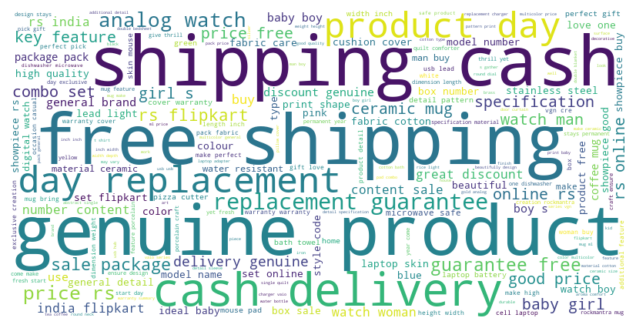

In [43]:
# Fusionner toutes les descriptions de produits en une seule chaîne de caractères
texte = ' '.join(data['product_description'])

# Créer un objet WordCloud
nuage_mots = WordCloud(width=800, height=400, background_color='white').generate(texte)

# Afficher le nuage de mots en utilisant matplotlib
plt.figure(figsize=(8, 4))
plt.imshow(nuage_mots, interpolation='bilinear')
plt.axis('off')
plt.show()

## Extraction des features texte
Pour l'extraction des caractéristiques textuelles, nous avons implémenté plusieurs approches. Nous avons utilisé des méthodes de type "bag-of-words" telles que le comptage simple des mots et le TF-IDF. De plus, nous avons appliqué une approche classique de word/sentence embedding en utilisant Word2Vec. Nous avons également exploré des approches plus avancées de word/sentence embedding en utilisant BERT et USE (Universal Sentence Encoder). Ces différentes approches nous permettent de capturer différentes représentations des textes, ce qui nous permet d'effectuer une analyse plus approfondie des données textuelles.

### bag-of-words  : comptage de mots

Le modèle de sac de mots standard pour les données textuelles représente chaque document par un vecteur de fréquences de mots. Il ignore l'ordre des mots et se concentre uniquement sur leur occurrence. Cela permet de convertir les données textuelles en une représentation numérique utilisable, mais ne prend pas en compte les relations ou le contexte entre les mots.

In [44]:

# Création du vecteur de comptage de mots (bag-of-words) à partir des données textuelles
def create_bag_of_words(data, column, frequency_threshold=0, normalize_words=True):
    vectorizer = CountVectorizer(lowercase=True, stop_words='english', min_df=frequency_threshold)
    X_counts = vectorizer.fit_transform(data[column])

    if normalize_words:
        word_counts = X_counts.sum(axis=0)
        max_count = word_counts.max()
        X_counts = X_counts / max_count

    return X_counts

bag_counts = create_bag_of_words(data, 'product_description', frequency_threshold=0, normalize_words=True)

### bag-of-words  : Tf-idf


### TF-IDF (Term Frequency-Inverse Document Frequency)

Le TF-IDF (Term Frequency-Inverse Document Frequency) est une mesure utilisée en traitement de texte pour évaluer l'importance d'un terme dans un document. Elle combine la fréquence d'un terme dans le document (TF) avec son importance globale dans la collection de documents (IDF). Le TF-IDF est largement utilisé pour la classification de texte, la recherche d'informations et la recommandation de contenu personnalisé.

Le TF mesure la fréquence d'un terme dans le document, en le divisant par le nombre total de termes dans ce document. Cela permet de quantifier la fréquence relative du terme dans le contexte du document.

L'IDF est calculé en prenant le logarithme du rapport entre le nombre total de documents dans la collection et le nombre de documents contenant le terme spécifique. Cela permet de valoriser les termes rares qui ont une pertinence plus élevée.

In [45]:
# Création du vecteur bag-of-words à partir des données textuelles
def create_bag_of_words(data, column, frequency_threshold=0, normalize_words=True):
    vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', min_df=frequency_threshold)
    X_tfidf = vectorizer.fit_transform(data[column])

    if normalize_words:
        word_counts = X_tfidf.sum(axis=0)
        max_count = word_counts.max()
        X_tfidf = X_tfidf / max_count

    return X_tfidf

bag_tfidf = create_bag_of_words(data, 'product_description', frequency_threshold=0, normalize_words=True)

### word/sentence embedding

Les embeddings de mots et de phrases (word/sentence embedding) sont des techniques utilisées pour représenter les mots et les phrases sous forme de vecteurs numériques dans le domaine du traitement du langage naturel. Ces embeddings permettent de capturer les informations sémantiques et syntaxiques des mots et des phrases, ce qui facilite leur utilisation dans des tâches d'apprentissage automatique et d'analyse de texte.

- Word2Vec :
Word2Vec est une méthode populaire d'embedding de mots basée sur des modèles de langue neuronaux. Elle vise à représenter les mots sous forme de vecteurs denses dans un espace continu. Word2Vec capture les relations sémantiques et syntaxiques entre les mots en analysant le contexte dans lequel ils apparaissent dans un corpus de texte. Il crée des représentations vectorielles où des mots similaires sont placés à proximité dans l'espace vectoriel.
- BERT (Bidirectional Encoder Representations from Transformers) :
BERT est un modèle de langage pré-entrainé basé sur l'architecture des Transformers. Il est capable de capturer les relations complexes entre les mots et de comprendre le contexte global d'une phrase. BERT est bidirectionnel, ce qui signifie qu'il prend en compte le contexte avant et après chaque mot pour générer des représentations vectorielles riches et contextuelles. Il est utilisé pour l'embedding de mots et de phrases et a atteint des performances remarquables dans de nombreuses tâches de traitement du langage naturel. 
- USE (Universal Sentence Encoder) :
USE est un modèle d'embedding de phrases pré-entrainé qui capture les informations sémantiques et syntaxiques d'une phrase dans un espace vectoriel. Il est capable de générer des embeddings de phrases qui préservent la similarité sémantique entre les phrases. Le modèle USE est multilingue et a été entrainé sur un large corpus de texte provenant de différentes langues. Il peut être utilisé pour des tâches telles que la recherche sémantique, la classification de texte et la traduction automatique.

### Word2Vec :

In [58]:
# Extraire les phrases du jeu de données
sentences = [sentence.split() for sentence in data['product_description']]

# Entraînement du modèle Word2Vec
model = Word2Vec(sentences, min_count=1)

# Fonction pour calculer l'embedding d'une phrase
def sentence_embedding(sentence):
    embeddings = []
    for word in sentence.split():
        if word in model.wv:
            embeddings.append(model.wv[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return None

# Calcul des embeddings pour toutes les phrases
embeddings = data['product_description'].apply(sentence_embedding)

# Suppression des lignes où l'embedding est nul
data = data[embeddings.notnull()]
embeddings_Word2Vec = embeddings.dropna().tolist()

### USE

In [134]:
import tensorflow_hub as hub
import tensorflow_text

# Charger le modèle USE pré-entraîné
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

# Fonction pour calculer l'embedding d'une phrase avec USE
def sentence_embedding(sentence):
    embeddings = use_model([sentence])
    return embeddings.numpy()[0]

# Calcul des embeddings pour toutes les phrases
embed_use = data['product_description'].apply(sentence_embedding)


In [150]:
!pip install transformers

### BERT

In [151]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer

# Charger les données
descriptions = data['product_description']

# Modèle BERT
model_name = 'bert-base-uncased'
bert_model = TFBertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Fonction pour encoder les descriptions avec BERT
def encode_descriptions(descriptions):
    max_length = 64
    tokenized_inputs = tokenizer.batch_encode_plus(
        descriptions,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )
    input_ids = tokenized_inputs['input_ids']
    attention_mask = tokenized_inputs['attention_mask']
    outputs = bert_model(input_ids, attention_mask=attention_mask)
    embeddings = outputs.pooler_output
    return embeddings

# Encoder les descriptions avec BERT
embeddings_bert = encode_descriptions(descriptions)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [50]:

# Charger les données
descriptions = sample_data['product_description']

# Modèle BERT
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

# Fonction pour encoder les descriptions avec BERT
def encode_descriptions(descriptions):
    max_length = 64
    batch_size = 10
    tokenizer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    tokenized_inputs = tokenizer(descriptions)
    bert_inputs = dict(tokenized_inputs)
    bert_inputs = {key: tf.squeeze(bert_inputs[key]) for key in bert_inputs}
    embeddings = bert_layer(bert_inputs)["pooled_output"]
    return embeddings
# Encoder les descriptions avec BERT
embeddings_bert = encode_descriptions(descriptions)

2023-06-18 04:00:51.673981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-18 04:00:51.674861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-18 04:00:51.675074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-18 04:00:51.675770: I tensorflow/core/

### Réduction de dimension : affichage des 2 composantes du T-SNE
### comptage de mots

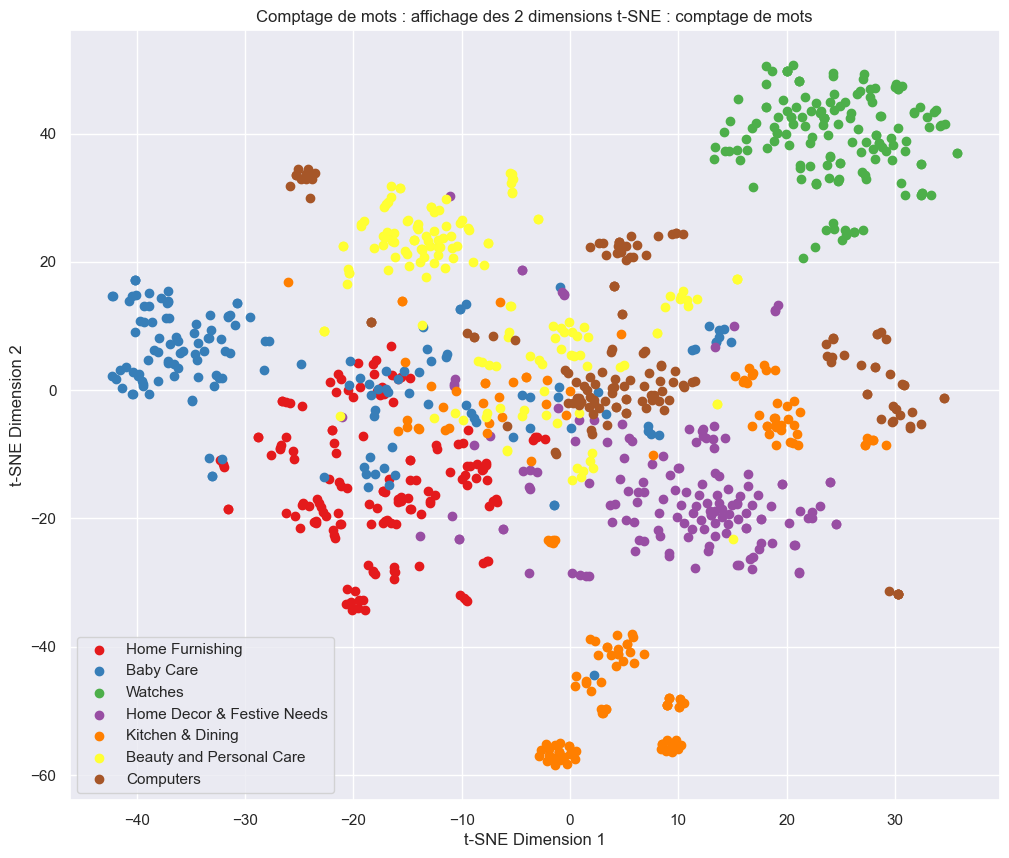

In [125]:
# Définition du thème seaborn
sns.set_theme()

# Calcul de la transformation t-SNE sur les données de comptage de mots
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(bag_counts.toarray())

# Création du graphique de dispersion
fig = plt.figure(figsize=(12, 10))

# Génération automatique des couleurs avec seaborn
num_categories = len(data['categorie'].unique())
colors = sns.color_palette('Set1', num_categories)

target_names = data['categorie'].unique()

for i, target_name in enumerate(target_names):
    plt.scatter(x=tsne_result[data['categorie'] == target_name, 0], y=tsne_result[data['categorie'] == target_name, 1], color=colors[i], label=target_name)

plt.legend()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Comptage de mots : affichage des 2 dimensions t-SNE : comptage de mots')

plt.show()


### Réduction de dimension : affichage des 2 composantes du T-SNE
### Tf-idf

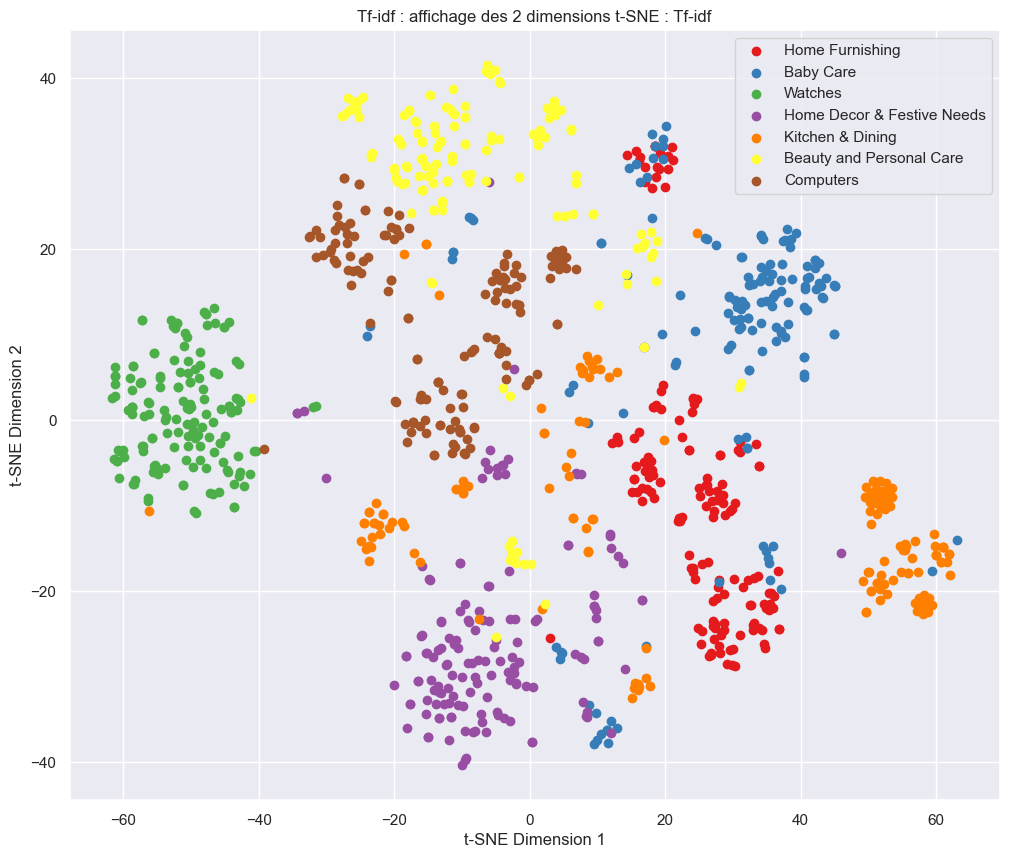

In [126]:
# Définition du thème seaborn
sns.set_theme()

# Calcul de la transformation t-SNE sur les données Tf-idf
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(bag_tfidf.toarray())

# Création du graphique de dispersion
fig = plt.figure(figsize=(12, 10))

# Génération automatique des couleurs avec seaborn
num_categories = len(data['categorie'].unique())
colors = sns.color_palette('Set1', num_categories)

target_names = data['categorie'].unique()

for i, target_name in enumerate(target_names):
    plt.scatter(x=tsne_result[data['categorie'] == target_name, 0], y=tsne_result[data['categorie'] == target_name, 1], color=colors[i], label=target_name)

plt.legend()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Tf-idf : affichage des 2 dimensions t-SNE : Tf-idf')
plt.show()

### Réduction de dimension : affichage des 2 composantes du T-SNE
### Word2Vec

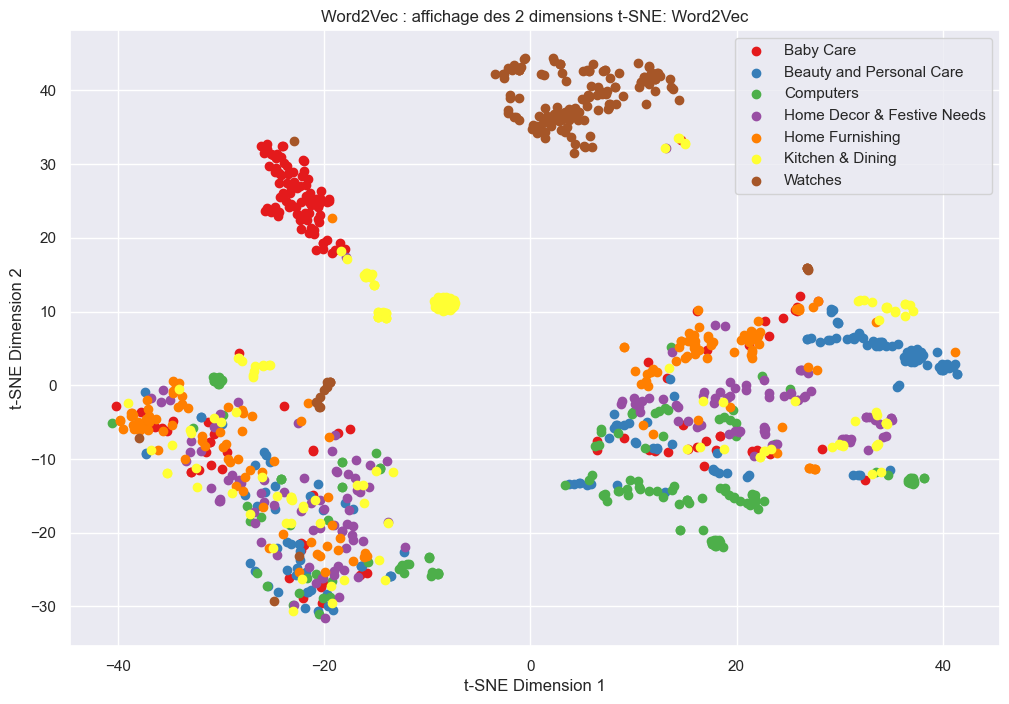

In [127]:
# Réduction de dimension avec T-SNE
tsne = TSNE(n_components=2)
# Convertir la liste en un tableau NumPy
embeddings_Word2Vec = np.array(embeddings_Word2Vec)
# Aplatir les données d'entrée
embedded = tsne.fit_transform(embeddings_Word2Vec)

# Récupération de la variable de couleur 
categories = data['categorie']
# Reste du code pour générer le graphique t-SNE


# Récupération de la variable de couleur (par exemple, la colonne 'category' dans les données)
categories = data['categorie']
# Récupération des catégories uniques et leur nombre
unique_categories = np.unique(categories)
num_categories = len(unique_categories)

# Génération d'une palette de couleurs unique pour chaque catégorie
color_palette = sns.color_palette('Set1', num_categories)

# Agrandir la taille du graphique
fig = plt.figure(figsize=(12, 8))

# Affichage des deux composantes du T-SNE avec une couleur unique pour chaque catégorie
for i, category in enumerate(unique_categories):
    category_indices = np.where(categories == category)[0]
    plt.scatter(embedded[category_indices, 0], embedded[category_indices, 1], color=color_palette[i], label=category)

plt.legend()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Word2Vec : affichage des 2 dimensions t-SNE: Word2Vec')
plt.show()

### Réduction de dimension : affichage des 2 composantes du T-SNE
### USE

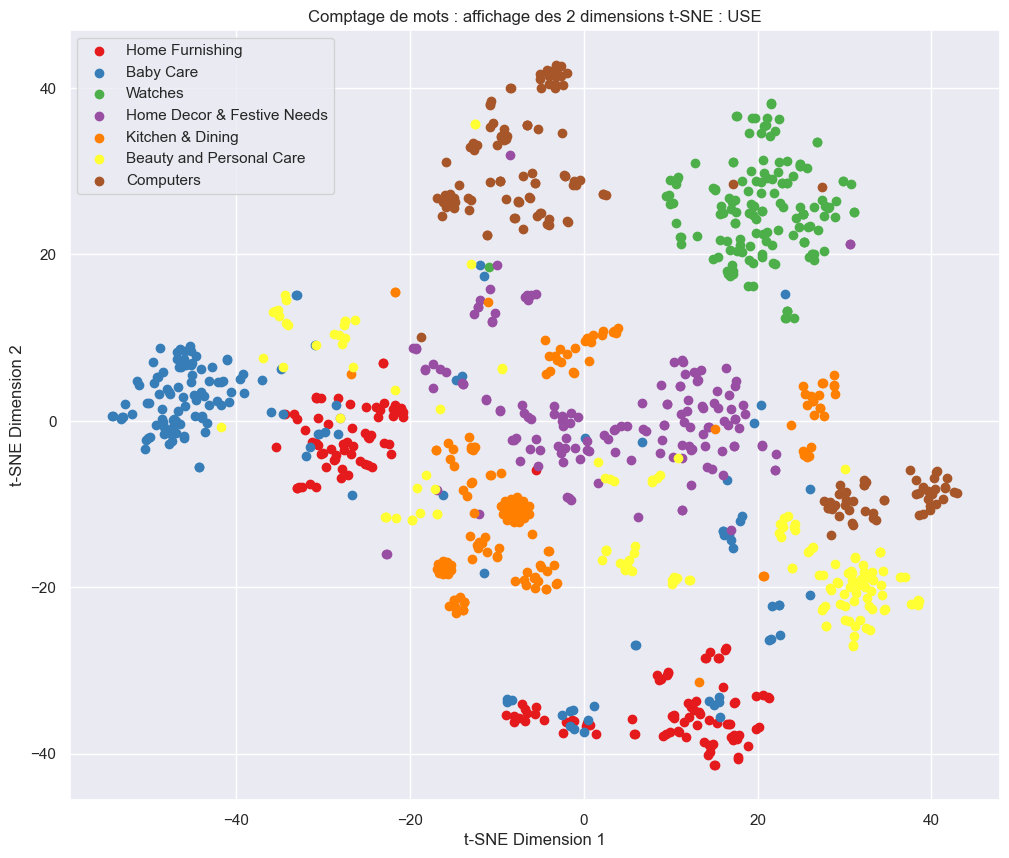

In [140]:
# Définition du thème seaborn
sns.set_theme()

# Calcul de la transformation t-SNE sur les données de comptage de mots
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(np.vstack(embed_use))

# Création du graphique de dispersion
fig = plt.figure(figsize=(12, 10))

# Génération automatique des couleurs avec seaborn
num_categories = len(data['categorie'].unique())
colors = sns.color_palette('Set1', num_categories)

target_names = data['categorie'].unique()

for i, target_name in enumerate(target_names):
    plt.scatter(x=tsne_result[data['categorie'] == target_name, 0], y=tsne_result[data['categorie'] == target_name, 1], color=colors[i], label=target_name)

plt.legend()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Comptage de mots : affichage des 2 dimensions t-SNE : USE')

plt.show()


### Réduction de dimension : affichage des 2 composantes du T-SNE
### BERT

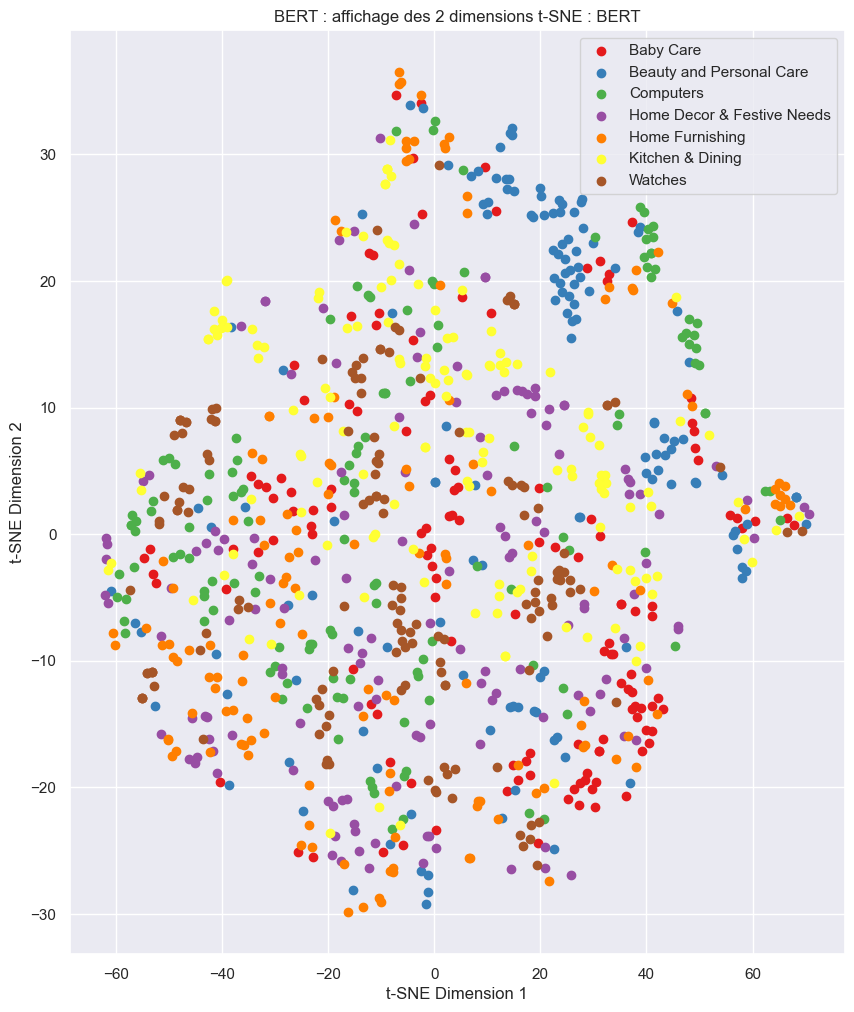

In [152]:
# Réduction de dimension avec T-SNE
tsne = TSNE(n_components=2)
embedded = tsne.fit_transform(np.vstack(embeddings_bert))  # Utilisation de np.vstack() pour créer un tableau NumPy

# Récupération la colonne 'category' dans les données)
categories = sample_data['categorie']  

# Récupération des catégories uniques et leur nombre
unique_categories = np.unique(categories)
num_categories = len(unique_categories)

# Génération d'une palette de couleurs unique pour chaque catégorie
color_palette = sns.color_palette('Set1', num_categories)

# Agrandir la taille du graphique
fig = plt.figure(figsize=(10, 12))

# Affichage des deux composantes du T-SNE avec une couleur unique pour chaque catégorie
for i, category in enumerate(unique_categories):
    category_indices = np.where(categories == category)[0]
    plt.scatter(embedded[category_indices, 0], embedded[category_indices, 1], color=color_palette[i], label=category)

plt.legend()
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('BERT : affichage des 2 dimensions t-SNE : BERT')
plt.show()



## Classification : Tf-idf
### Classification : LogisticRegression

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Calcul de la transformation t-SNE sur les données Tf-idf
tsne = TSNE(n_components=2, random_state=42)
tsne_tfidf = tsne.fit_transform(bag_tfidf.toarray())

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(tsne_tfidf, data['categorie'], test_size=0.15, random_state=0)

# Création et entraînement du modèle de régression logistique
logreg = LogisticRegression(C=0.2, max_iter=50)
logreg.fit(X_train, y_train)

# Évaluation du modèle
train_accuracy = logreg.score(X_train, y_train)
test_accuracy = logreg.score(X_test, y_test)

print('test_accuracy:', test_accuracy)


test_accuracy: 0.6645569620253164


/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Classification : RandomForestClassifier

In [64]:
from sklearn.ensemble import RandomForestClassifier

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(bag_tfidf, data['categorie'], test_size=0.3, random_state=0)

# Création et entraînement du modèle Random Forest
random_forest = RandomForestClassifier(n_estimators=500, random_state=42)
random_forest.fit(X_train, y_train)

# Évaluation du modèle
test_accuracy = random_forest.score(X_test, y_test)
print('test_accuracy:', test_accuracy)


test_accuracy: 0.9079365079365079


### Confusion matrix : RandomForestClassifier

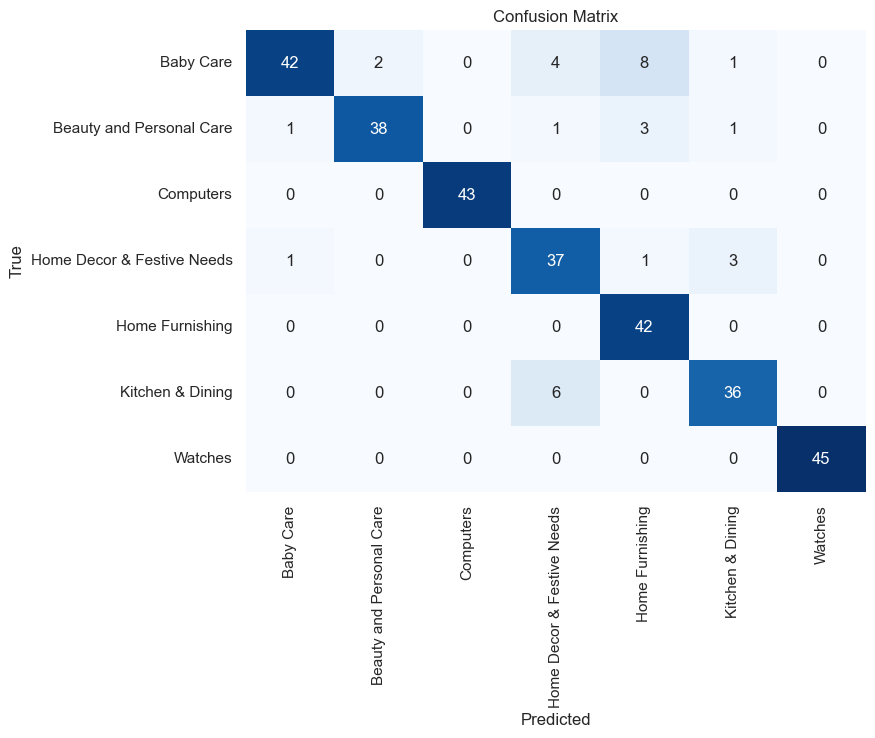

In [65]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(data['product_description'], data['categorie'], test_size=0.3, random_state=0)

# Vectorizing the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Creating and training the RandomForestClassifier model
random_forest = RandomForestClassifier(n_estimators=500, random_state=42)
random_forest.fit(X_train_tfidf, y_train)

# Making predictions on the test set
predictions = random_forest.predict(X_test_tfidf)

# Create confusion matrix with all class labels
all_labels = sorted(data['categorie'].unique())
cm = confusion_matrix(y_test, predictions, labels=all_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=all_labels, yticklabels=all_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Confusion matrix : LogisticRegression

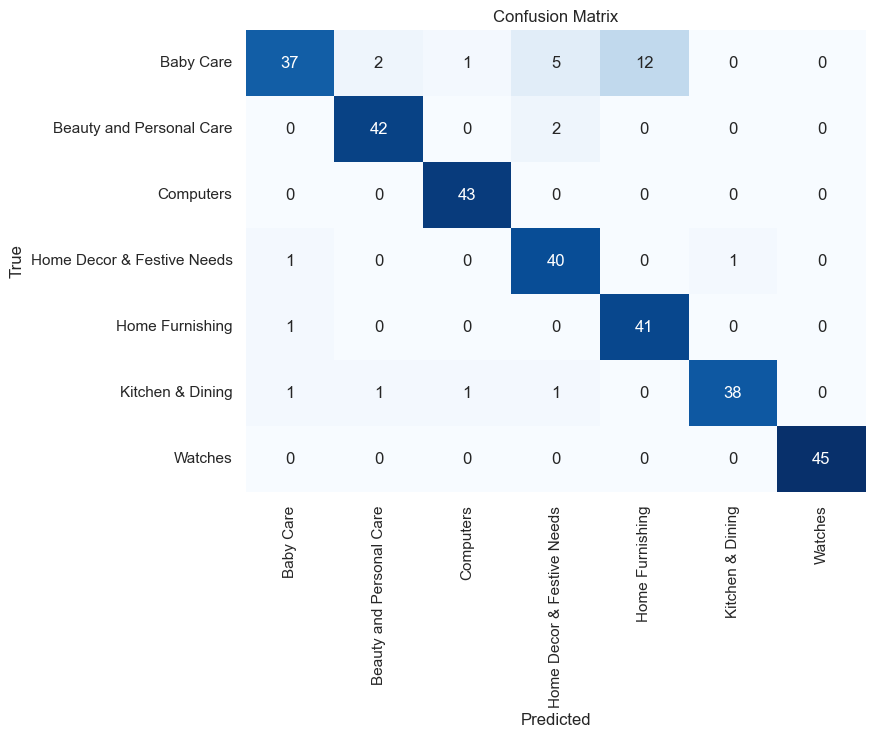

In [66]:
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(data['product_description'], data['categorie'], test_size=0.3, random_state=0)

# Vectorizing the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Creating and training the Logistic Regression model
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_tfidf, y_train)

# Making predictions on the test set
predictions = logistic_regression.predict(X_test_tfidf)

# Create confusion matrix with all class labels
all_labels = sorted(data['categorie'].unique())
cm = confusion_matrix(y_test, predictions, labels=all_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=all_labels, yticklabels=all_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [67]:
# Enregistrez le DataFrame en tant que fichier csv à l'aide de la méthode to_csv() 
data.to_csv('data.csv', index=False)

##  Affichage des images selon clusters 

In [115]:
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def visualize_and_evaluate(X, labels, data_name):
    # Réduction de dimension avec T-SNE
    tsne = TSNE(n_components=2, init="random")  # Utilisation de l'initialisation "random"
    X_tsne = tsne.fit_transform(X)

    # Clustering avec K-means
    cls = KMeans(n_clusters=7, random_state=6)
    cls.fit(X_tsne)
    predicted_labels = cls.labels_

    # Agrandir la taille de la figure
    plt.figure(figsize=(10, 8))

    # Affichage des points avec les labels prédits
    unique_labels = set(predicted_labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))
    for label in unique_labels:
        indices = predicted_labels == label
        plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], color=colors(label), label=label)

    plt.title("Visualisation des features texte extraites - " + data_name)

    plt.legend(title="Cluster Labels")

    plt.show()

    # Création d'un encodeur de labels
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(labels)

    # Calcul de l'indice ARI
    ari = adjusted_rand_score(true_labels, predicted_labels)
    print("Adjusted Rand Index (ARI):", ari)


### bag_counts

/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


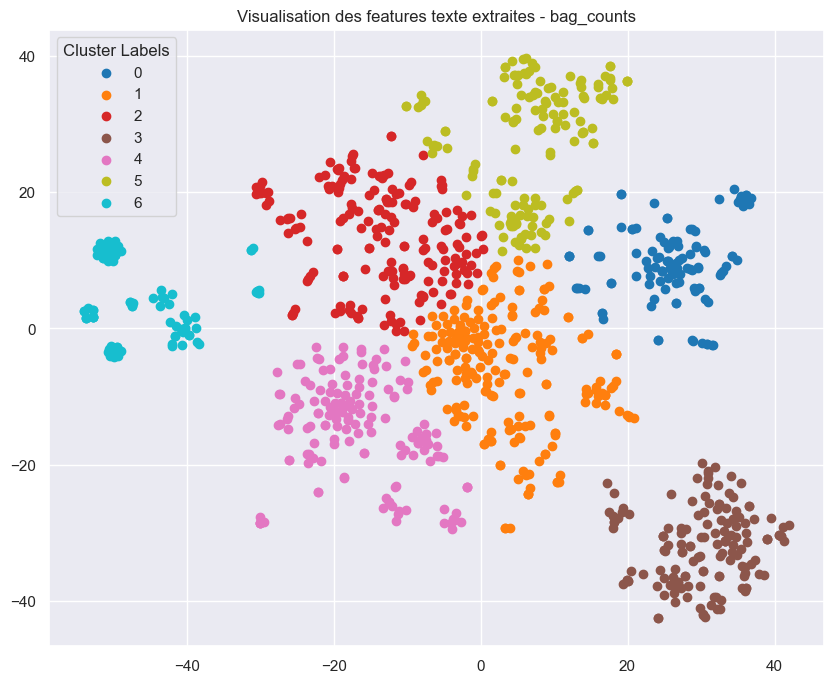

Adjusted Rand Index (ARI): 0.47104676549298047


In [116]:
visualize_and_evaluate(bag_counts, data['categorie'], 'bag_counts')

### bag_tf-idf

/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


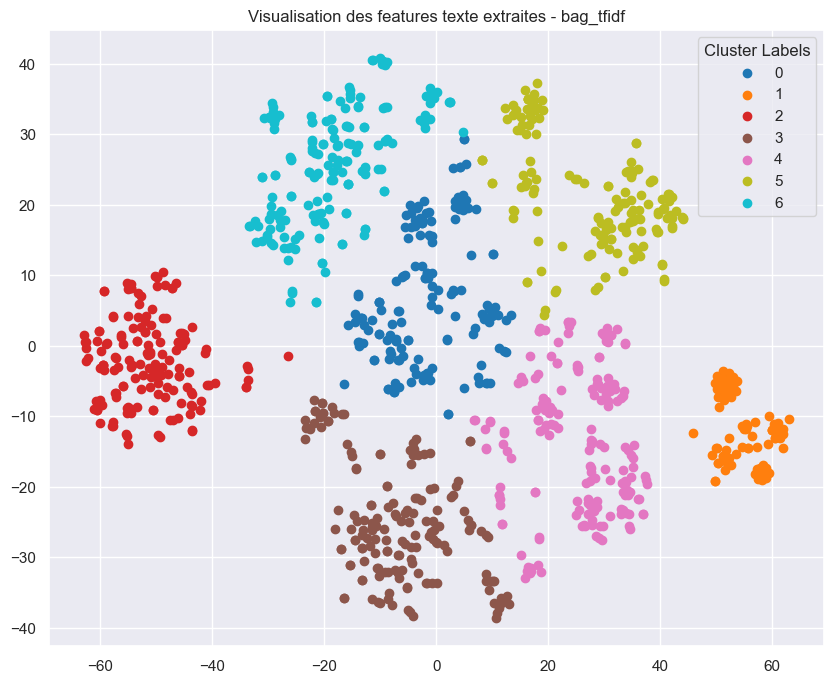

Adjusted Rand Index (ARI): 0.5362966162627018


In [117]:
visualize_and_evaluate(bag_tfidf, data['categorie'], 'bag_tfidf')

### embeddings_Word2Vec

/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


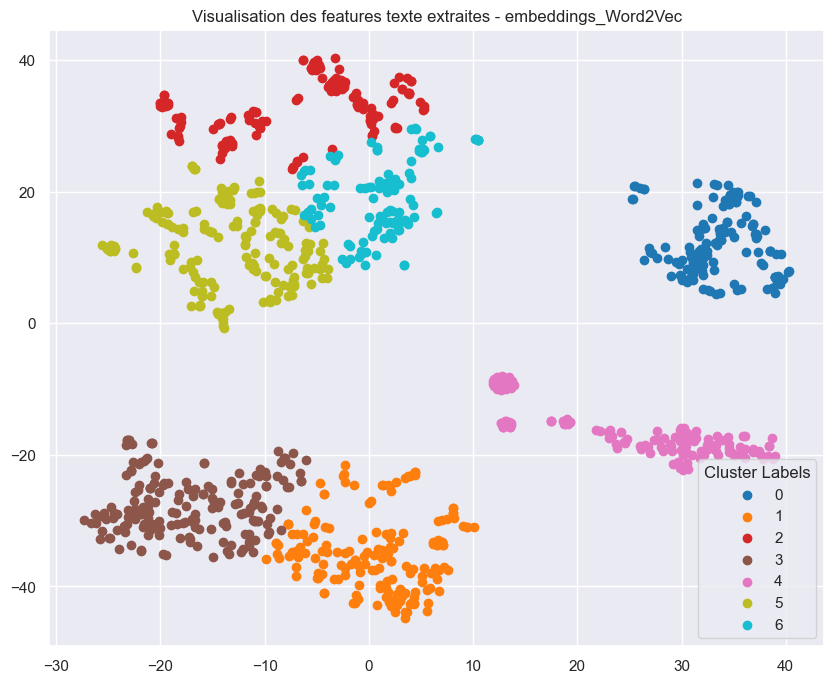

Adjusted Rand Index (ARI): 0.23508921871154373


In [118]:
visualize_and_evaluate(embeddings_Word2Vec, data['categorie'], 'embeddings_Word2Vec')

### USE

/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


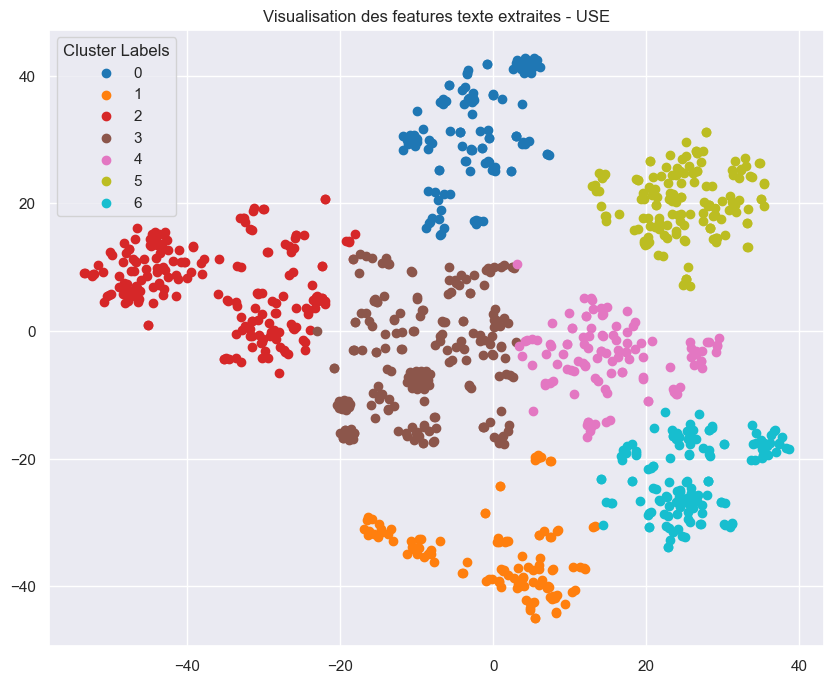

Adjusted Rand Index (ARI): 0.4562995787989281


In [138]:
visualize_and_evaluate(np.vstack(embed_use), data['categorie'], 'USE')

### BERT

/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


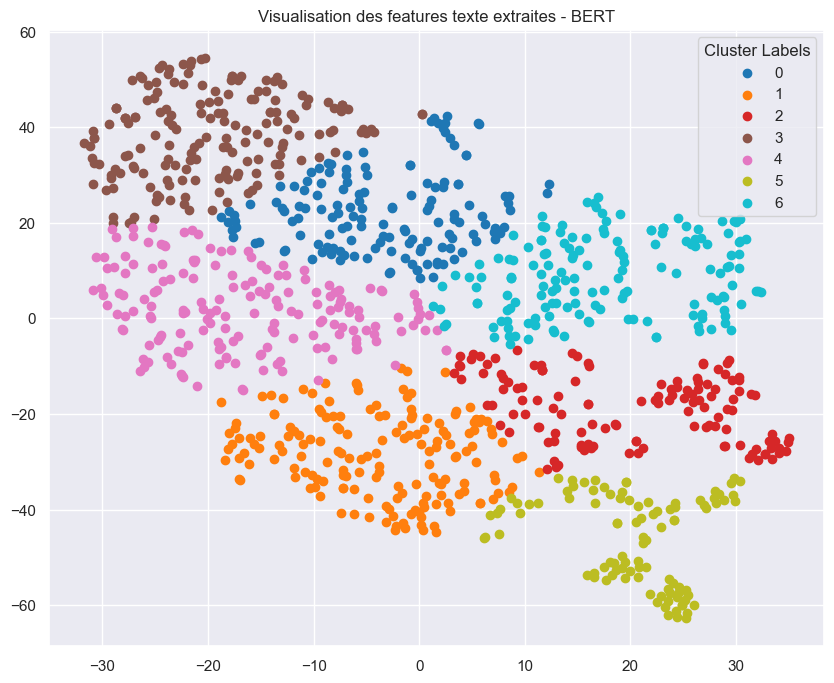

Adjusted Rand Index (ARI): 0.027926440249581422


In [153]:
visualize_and_evaluate(embeddings_bert, data['categorie'], 'BERT')